In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from tabulate import tabulate

from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [246]:
modelling_df = pd.read_csv('Dataset/output_dataset.csv')

In [247]:
# Convert 'country', 'account_currency', 'Trading_Method' and 'active' to categorical
modelling_df['country'] = modelling_df['country'].astype('category')
modelling_df['account_currency'] = modelling_df['account_currency'].astype('category')
modelling_df['Trading_Method'] = modelling_df['Trading_Method'].astype('category')
modelling_df['active'] = modelling_df['active'].astype('category')
modelling_df['has_credit'] = modelling_df['has_credit'].astype('category')

Split the Dataset

In [248]:
# Sort the DataFrame by 'longevity'
modelling_df = modelling_df.sort_values(by=['longevity'])

split_index = 5000

# Split the dataset
top_10_percent = modelling_df.iloc[split_index:]
bottom_90_percent = modelling_df.iloc[0:split_index]

In [249]:
bottom_90_percent['longevity'].describe()

count    5000.00000
mean       23.18360
std        28.66604
min         0.00000
25%         1.00000
50%        10.00000
75%        37.00000
max       112.00000
Name: longevity, dtype: float64

In [250]:
top_10_percent['longevity'].describe()

count    725.000000
mean     197.295172
std       81.048097
min      112.000000
25%      134.000000
50%      173.000000
75%      237.000000
max      415.000000
Name: longevity, dtype: float64

# Functions and Defintions

In [251]:
# Define regression models
regression_models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(criterion='squared_error'),
    "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', max_depth='5', eta='0.05', eval_metric='rmse', alpha='0.1', reg_lambda='1'),  
    # "Neural Network Regressor": MLPRegressor(max_iter=10000),
    # "Linear Regression": LinearRegression(),
    # "Ridge Regression": Ridge(),
    # "Lasso Regression": Lasso(),
    # "KNeighbors Regressor": KNeighborsRegressor(),
    # "Support Vector Regressor": SVR()
}

In [252]:
def DisplayFeatureImportanceOrCoefficients(model, X_preprocessed_df):
    if hasattr(model, 'feature_importances_'):
        feature_importances = list(zip(X_preprocessed_df.columns, model.feature_importances_))
        headers = ["Feature", "Importance"]
        print("Feature Importances:")
        print("Original:")
        print(tabulate(feature_importances, headers=headers, tablefmt="rounded_outline"))
        print("\nSorted:")
        feature_importances_sorted = sorted(feature_importances, key=lambda x: x[1], reverse=True)
        print(tabulate(feature_importances_sorted, headers=headers, tablefmt="rounded_outline"))
    elif hasattr(model, 'coef_'):
        feature_coefficients = list(zip(X_preprocessed_df.columns, model.coef_))
        headers = ["Feature", "Coefficient"]
        print("Feature Coefficients:")
        print("Original:")
        print(tabulate(feature_coefficients, headers=headers, tablefmt="rounded_outline"))
        print("\nSorted (by absolute value):")
        feature_coefficients_sorted = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)
        print(tabulate(feature_coefficients_sorted, headers=headers, tablefmt="rounded_outline"))
    else:
        print("Feature importance or coefficients not available for this model.")


In [253]:
def DisplayMetrics(model, X, y, metricType):
    y_pred = model.predict(X)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    headers = [metricType, "Value"]
    data = [
        ["Mean Absolute Error (MAE)", f"{mae:.4f}"],
        ["Mean Squared Error (MSE)", f"{mse:.4f}"],
        ["Root Mean Squared Error (RMSE)", f"{rmse:.4f}"],
        ["R-squared (R2)", f"{r2:.4f}"]
    ]
    
    print(tabulate(data, headers=headers, tablefmt="rounded_outline"))
    print()
    
    return y_pred

In [254]:
def PerformPlot(name, y_test, y_test_pred, limits):
    # Plotting true vs predicted values for test set
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(y_test, y_test_pred, color='blue')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_xlabel('True Values', fontsize=18)
    ax.set_ylabel('Predicted Values', fontsize=18)
    ax.set_title('True vs Predicted Values (Test Set)', fontsize=14)
    plt.suptitle(name, fontsize=24)
    plt.show()

# Bottom 90 Model

In [255]:
bottom_90_percent

,login,country,account_currency,Trading_Frequency,Total_Trades,Buy_Percentage,Average_Volume,Average_Volume_USD,Average_DPM,Unique_Symbols_Traded,...,Average_Commission,Average_Swaps,Average_Profit,average_net_deposit,has_credit,active,net_deposit_frequency_ratio,Trading_Method,longevity,longevity_bin
2097,818031,France,EUR,3.000000,3,33.333333,0.353333,1.829080e+04,-1869.175905,1.00,...,0.0,-1.647902,-71.788758,0.996188,0.0,False,0.010000,Mobile,0,0
1674,816318,Spain,EUR,6.000000,6,100.000000,0.635000,1.719769e+09,673.283957,2.00,...,0.0,0.000000,154.373683,-4.210000,0.0,False,0.005025,Mobile,0,0
4776,7058560,Vietnam,USD,1.000000,1,0.000000,1.000000,4.031870e+05,-677.105165,1.00,...,0.0,0.000000,-273.000000,2.904255,0.0,False,0.032967,Client,0,0
3896,7055387,Indonesia,USD,1.000000,1,0.000000,0.400000,1.593328e+05,-1064.438709,1.00,...,0.0,0.000000,-169.600000,1.437288,0.0,False,0.026087,Client,0,0
3893,7055376,Indonesia,USD,4.000000,4,0.000000,0.192500,7.627496e+04,-1988.777840,1.00,...,0.0,10.885000,-103.000000,3.203390,0.0,False,0.026087,Client,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,814386,Canada,USD,0.464286,52,32.692308,0.221346,8.849495e+08,45.209371,2.80,...,0.0,-14.868846,-59.252115,38.263384,0.0,False,0.007663,Mobile,112,2
2207,818484,Nigeria,USD,1.437500,161,32.919255,0.028323,9.181700e+06,-201.757909,9.25,...,0.0,0.000559,-0.619317,0.495050,0.0,False,0.004975,Mobile,112,2
2694,820797,Switzerland,USD,6.223214,697,51.076040,0.097532,4.084884e+06,154.957314,8.75,...,0.0,-0.066212,-0.087030,8.092486,0.0,False,0.017647,Client,112,2
2267,818757,Lithuania,EUR,2.535714,284,39.084507,0.017113,6.605956e+03,-199.118226,2.50,...,0.0,0.040668,-1.268344,1.495025,0.0,False,0.015306,Mobile,112,2


In [256]:
# Remove specified columns and set 'longevity' as the target variable
X = bottom_90_percent.drop(columns=['login', 'Total_Trades', 'active', 'Average_Volume', 'longevity', 'longevity_bin'])
y = bottom_90_percent['longevity']

In [257]:
# List of all numeric columns
all_numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
categorical_cols = ['country', 'account_currency', 'Trading_Method', 'has_credit']  # Specified based on the dataset information provided earlier

# Columns to exclude from scaling
exclude_scaling = ['Buy_Percentage', 'TP/SL Hit Ratio', 'Reward_Risk_Ratio', 'Ratio_Profitable_Trades', 'net_deposit_frequency_ratio']

# Numeric columns to be scaled
numeric_cols_to_scale = [col for col in all_numeric_cols if col not in exclude_scaling]

# Create transformers for numeric and categorical data
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder()

# Create a column transformer to apply the appropriate transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num_to_scale', numeric_transformer, numeric_cols_to_scale),
        ('num_no_scale', 'passthrough', exclude_scaling),  # Pass through without scaling
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the features
X_preprocessed = preprocessor.fit_transform(X)

# Get numeric feature names directly for scaled and non-scaled
numeric_feature_names = numeric_cols_to_scale + exclude_scaling

# Combine all feature names
all_feature_names_corrected = numeric_feature_names + categorical_cols

# Creating the complete feature DataFrame with the correct feature names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names_corrected)

In [258]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed_df, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/0.85, random_state=42)

print(f"Train Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")
print(f"Validation Set Size: {X_val.shape[0]}")

Train Set Size: 3500
Test Set Size: 750
Validation Set Size: 750


Decision Tree Regressor - Bottom 90
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │   0.182048   │
│ Average_Volume_USD          │   0.0259233  │
│ Average_DPM                 │   0.0442377  │
│ Unique_Symbols_Traded       │   0.0341365  │
│ Peak_Trading_Times          │   0.0185557  │
│ Profit_Loss_Variability     │   0.0273676  │
│ Average_Trade_Duration      │   0.0443177  │
│ Average_Commission          │   0.00610159 │
│ Average_Swaps               │   0.0799088  │
│ Average_Profit              │   0.0729169  │
│ average_net_deposit         │   0.068054   │
│ Buy_Percentage              │   0.0528314  │
│ TP/SL Hit Ratio             │   0.170685   │
│ Reward_Risk_Ratio           │   0.00875395 │
│ Ratio_Profitable_Trades     │   0.0461727  │
│ net_deposit_frequency_ratio │   0.0485061  │
│ country                     │   0.0509

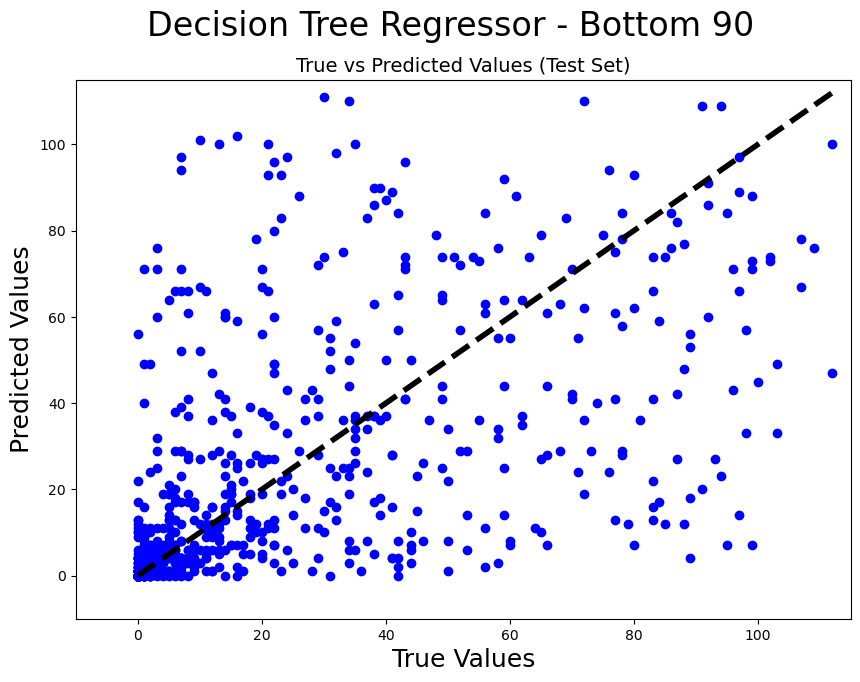

Random Forest Regressor - Bottom 90
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │   0.188987   │
│ Average_Volume_USD          │   0.0280516  │
│ Average_DPM                 │   0.041827   │
│ Unique_Symbols_Traded       │   0.0290626  │
│ Peak_Trading_Times          │   0.0178591  │
│ Profit_Loss_Variability     │   0.0396511  │
│ Average_Trade_Duration      │   0.0418485  │
│ Average_Commission          │   0.00897593 │
│ Average_Swaps               │   0.0714829  │
│ Average_Profit              │   0.0511647  │
│ average_net_deposit         │   0.0638162  │
│ Buy_Percentage              │   0.0454138  │
│ TP/SL Hit Ratio             │   0.179077   │
│ Reward_Risk_Ratio           │   0.0107315  │
│ Ratio_Profitable_Trades     │   0.0672392  │
│ net_deposit_frequency_ratio │   0.0546007  │
│ country                     │   0.0374

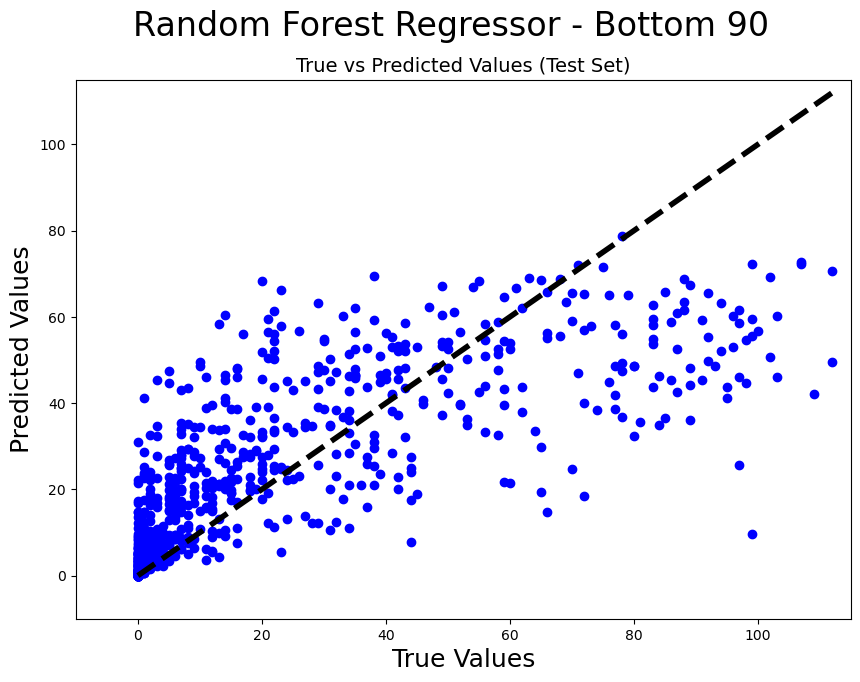

XGBoost Regressor - Bottom 90
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │    0.0675917 │
│ Average_Volume_USD          │    0.0190242 │
│ Average_DPM                 │    0.0386806 │
│ Unique_Symbols_Traded       │    0.0246255 │
│ Peak_Trading_Times          │    0.0345085 │
│ Profit_Loss_Variability     │    0.0428662 │
│ Average_Trade_Duration      │    0.0324113 │
│ Average_Commission          │    0.0190806 │
│ Average_Swaps               │    0.093849  │
│ Average_Profit              │    0.0470356 │
│ average_net_deposit         │    0.0426552 │
│ Buy_Percentage              │    0.0530671 │
│ TP/SL Hit Ratio             │    0.203926  │
│ Reward_Risk_Ratio           │    0.0206647 │
│ Ratio_Profitable_Trades     │    0.0627848 │
│ net_deposit_frequency_ratio │    0.0339892 │
│ country                     │    0.042165  │

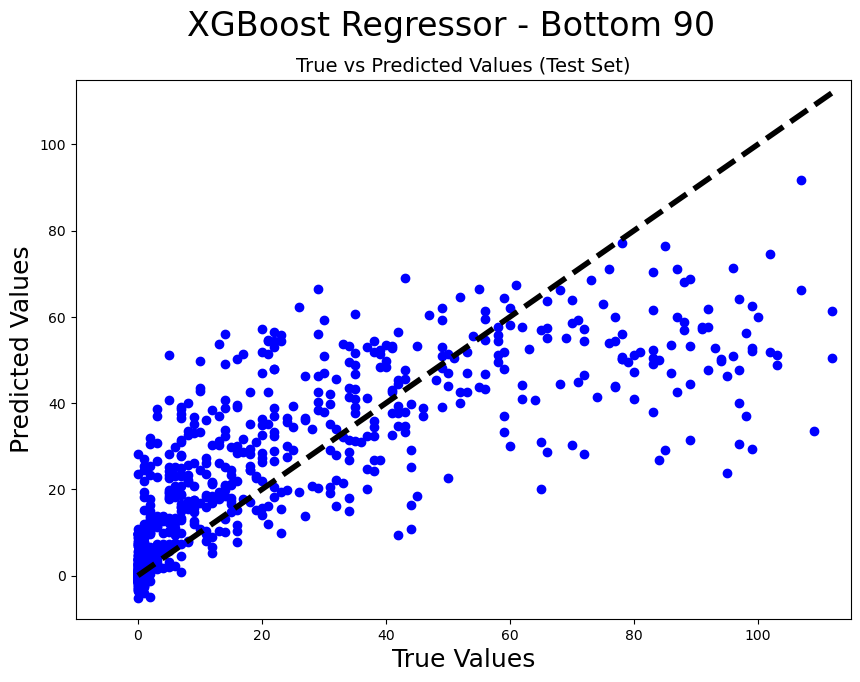

In [259]:
# Train and evaluate regression models
for name, model in regression_models.items():
    print(f"{name} - Bottom 90")
    # Train the model on the training set
    model.fit(X_train, y_train)

    DisplayFeatureImportanceOrCoefficients(model, X_preprocessed_df)

    # Evaluate Metrics on Model
    DisplayMetrics(model, X_val, y_val, "Validation")
    y_test_pred = DisplayMetrics(model, X_test, y_test, "Testing")

    PerformPlot(f"{name} - Bottom 90", y_test, y_test_pred, [-10, 115])

# Top 10 Model

In [260]:
top_10_percent

,login,country,account_currency,Trading_Frequency,Total_Trades,Buy_Percentage,Average_Volume,Average_Volume_USD,Average_DPM,Unique_Symbols_Traded,...,Average_Commission,Average_Swaps,Average_Profit,average_net_deposit,has_credit,active,net_deposit_frequency_ratio,Trading_Method,longevity,longevity_bin
2828,821433,Kenya,USD,1.303571,146,34.931507,0.089041,1.669980e+08,-176.581247,6.000000,...,0.000000,-0.010205,-2.625137,2.394639,1.0,False,0.037500,Mobile,112,2
826,811270,United Kingdom,GBP,0.522124,59,61.016949,1.261695,3.047270e+09,-43.792394,6.000000,...,0.000000,-0.244112,-11.880180,3.320513,0.0,False,0.012987,Mobile,113,2
2239,818620,Singapore,USD,22.672566,2562,55.854801,0.017717,5.283353e+03,-2.790800,1.000000,...,0.000000,-0.215543,0.780570,17.972200,0.0,False,0.041667,Expert,113,2
1408,814642,Israel,USD,3.451327,390,45.641026,0.043667,3.025630e+07,-275.624966,13.500000,...,0.000000,-0.006179,-0.772846,1.288958,1.0,False,0.019685,Mobile,113,2
3347,823613,Italy,EUR,0.787611,89,77.528090,0.024607,8.412865e+03,2357.972434,3.750000,...,0.000000,-1.264554,6.905020,8.371901,0.0,False,0.083969,Mobile,113,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,88944610,Canada,USD,0.356265,145,47.586207,0.025448,1.832140e+07,-90.848951,2.642857,...,-0.116345,-0.521793,-2.254483,1.099469,0.0,True,0.007299,Expert,407,5
5696,88944676,South Africa,USD,3.100490,1265,32.569170,1.445549,7.830123e+07,-41.410931,6.166667,...,-0.004980,0.007257,-17.009423,0.000000,1.0,True,0.000000,Expert,408,5
37,804893,France,USD,14.936275,6094,48.293403,0.077248,1.669919e+04,15.343162,1.000000,...,-0.540737,-0.007246,0.080876,9.798942,0.0,True,0.038462,Expert,408,5
5671,88944431,Romania,EUR,2.253623,933,53.590568,0.080182,1.258499e+07,-32.279963,1.230769,...,-0.053907,-0.358663,-1.062936,7.194245,0.0,True,0.004819,Expert,414,5


In [261]:
# Remove specified columns and set 'longevity' as the target variable
X = top_10_percent.drop(columns=['login', 'Total_Trades', 'active', 'Average_Volume', 'longevity', 'longevity_bin'])
y = top_10_percent['longevity']

In [262]:
# List of all numeric columns
all_numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
categorical_cols = ['country', 'account_currency', 'Trading_Method', 'has_credit']  # Specified based on the dataset information provided earlier

# Columns to exclude from scaling
exclude_scaling = ['Buy_Percentage', 'TP/SL Hit Ratio', 'Reward_Risk_Ratio', 'Ratio_Profitable_Trades', 'net_deposit_frequency_ratio']

# Numeric columns to be scaled
numeric_cols_to_scale = [col for col in all_numeric_cols if col not in exclude_scaling]

# Create transformers for numeric and categorical data
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder()

# Create a column transformer to apply the appropriate transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num_to_scale', numeric_transformer, numeric_cols_to_scale),
        ('num_no_scale', 'passthrough', exclude_scaling),  # Pass through without scaling
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the features
X_preprocessed = preprocessor.fit_transform(X)

# Get numeric feature names directly for scaled and non-scaled
numeric_feature_names = numeric_cols_to_scale + exclude_scaling

# Combine all feature names
all_feature_names_corrected = numeric_feature_names + categorical_cols

# Creating the complete feature DataFrame with the correct feature names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names_corrected)

In [263]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed_df, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/0.85, random_state=42)

print(f"Train Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")
print(f"Validation Set Size: {X_val.shape[0]}")

Train Set Size: 507
Test Set Size: 109
Validation Set Size: 109


Decision Tree Regressor - Top 10
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │   0.0612169  │
│ Average_Volume_USD          │   0.101038   │
│ Average_DPM                 │   0.0601353  │
│ Unique_Symbols_Traded       │   0.0438371  │
│ Peak_Trading_Times          │   0.0258238  │
│ Profit_Loss_Variability     │   0.0282717  │
│ Average_Trade_Duration      │   0.0644673  │
│ Average_Commission          │   0.0614619  │
│ Average_Swaps               │   0.0532453  │
│ Average_Profit              │   0.038992   │
│ average_net_deposit         │   0.0775887  │
│ Buy_Percentage              │   0.0506767  │
│ TP/SL Hit Ratio             │   0.0955031  │
│ Reward_Risk_Ratio           │   0.0557182  │
│ Ratio_Profitable_Trades     │   0.0163902  │
│ net_deposit_frequency_ratio │   0.0646598  │
│ country                     │   0.0503912

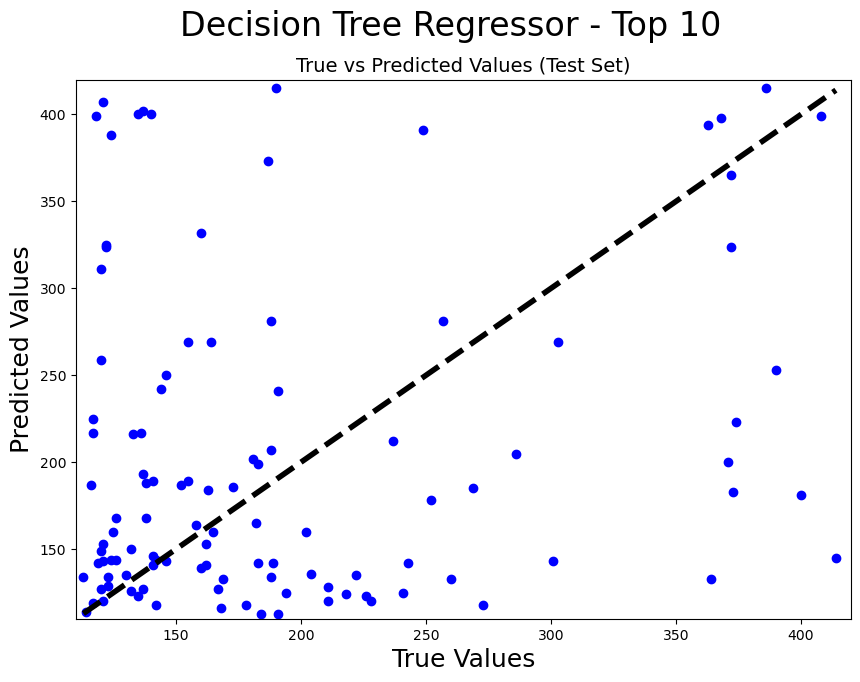

Random Forest Regressor - Top 10
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │   0.0700548  │
│ Average_Volume_USD          │   0.081492   │
│ Average_DPM                 │   0.0409778  │
│ Unique_Symbols_Traded       │   0.0520116  │
│ Peak_Trading_Times          │   0.0366979  │
│ Profit_Loss_Variability     │   0.040619   │
│ Average_Trade_Duration      │   0.0836086  │
│ Average_Commission          │   0.0557707  │
│ Average_Swaps               │   0.0393297  │
│ Average_Profit              │   0.041228   │
│ average_net_deposit         │   0.0527592  │
│ Buy_Percentage              │   0.0552725  │
│ TP/SL Hit Ratio             │   0.0911033  │
│ Reward_Risk_Ratio           │   0.0652861  │
│ Ratio_Profitable_Trades     │   0.0403424  │
│ net_deposit_frequency_ratio │   0.071388   │
│ country                     │   0.0372712

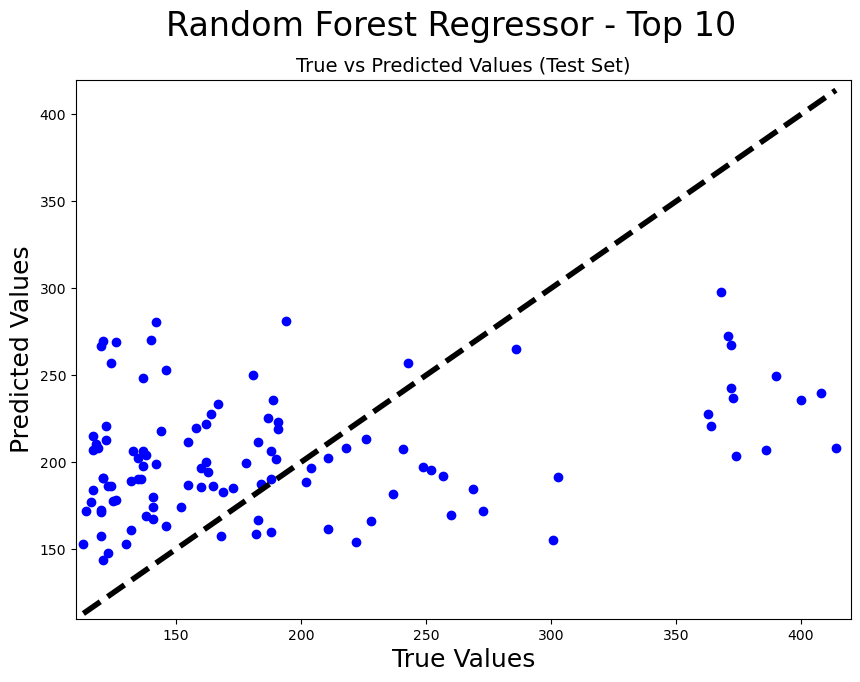

XGBoost Regressor - Top 10
Feature Importances:
Original:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │    0.0270625 │
│ Average_Volume_USD          │    0.0371136 │
│ Average_DPM                 │    0.028667  │
│ Unique_Symbols_Traded       │    0.027665  │
│ Peak_Trading_Times          │    0.0232134 │
│ Profit_Loss_Variability     │    0.0167611 │
│ Average_Trade_Duration      │    0.0616918 │
│ Average_Commission          │    0.0768939 │
│ Average_Swaps               │    0.0462968 │
│ Average_Profit              │    0.0527524 │
│ average_net_deposit         │    0.0496752 │
│ Buy_Percentage              │    0.0579942 │
│ TP/SL Hit Ratio             │    0.0946629 │
│ Reward_Risk_Ratio           │    0.0546698 │
│ Ratio_Profitable_Trades     │    0.0228285 │
│ net_deposit_frequency_ratio │    0.0729112 │
│ country                     │    0.0544324 │
│ 

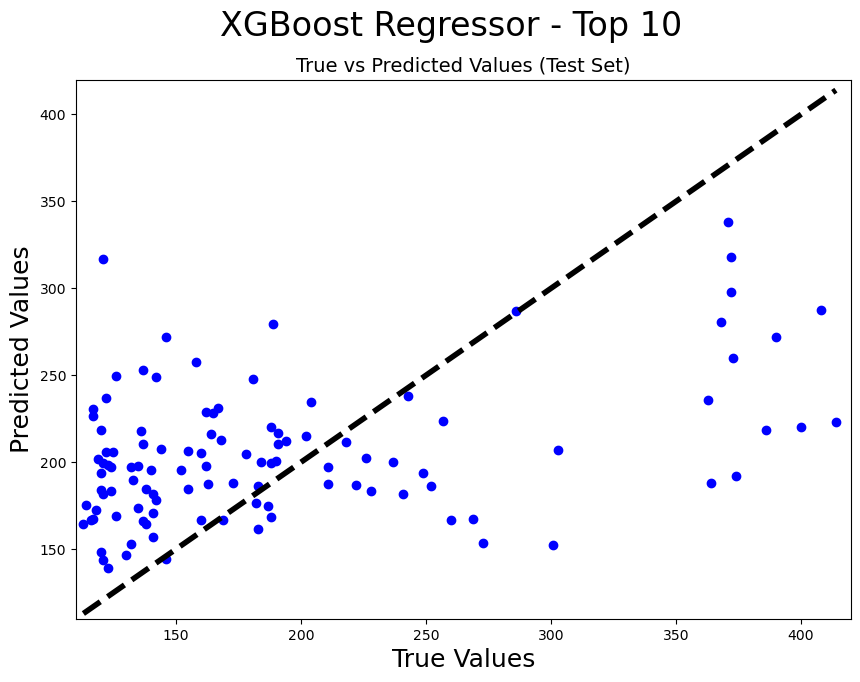

In [264]:
# Train and evaluate regression models
for name, model in regression_models.items():
    print(f"{name} - Top 10")
    # Train the model on the training set
    model.fit(X_train, y_train)

    DisplayFeatureImportanceOrCoefficients(model, X_preprocessed_df)

    # Evaluate Metrics on Model
    DisplayMetrics(model, X_val, y_val, "Validation")
    y_test_pred = DisplayMetrics(model, X_test, y_test, "Testing")

    PerformPlot(f"{name} - Top 10", y_test, y_test_pred, [110, 420])